Problem Understanding
* Text Regression problem: The task is given the tweet text, we are expected to predict whether the given tweet is positive, negetive or neutral. The target variable value ranges from (-1, 1)

## Setup

In [ ]:
! pip install fastai2 -q
! pip install nbdev -q

     |████████████████████████████████| 194kB 2.8MB/s 
     |████████████████████████████████| 51kB 1.7MB/s 


In [ ]:
import fastai2
print(fastai2.__version__)

0.0.17


## Download the Dataset

In [ ]:
! wget "https://fastaistudygroup.slack.com/files/URA50KQ7R/F0140NHLB8Q/zindi_vaccinate.zip"

--2020-05-17 16:48:37--  https://fastaistudygroup.slack.com/files/URA50KQ7R/F0140NHLB8Q/zindi_vaccinate.zip
Resolving fastaistudygroup.slack.com (fastaistudygroup.slack.com)... 3.229.174.54, 54.209.135.9, 54.227.211.227
Connecting to fastaistudygroup.slack.com (fastaistudygroup.slack.com)|3.229.174.54|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://fastaistudygroup.slack.com/?redir=%2Ffiles%2FURA50KQ7R%2FF0140NHLB8Q%2Fzindi_vaccinate.zip [following]
--2020-05-17 16:48:37--  https://fastaistudygroup.slack.com/?redir=%2Ffiles%2FURA50KQ7R%2FF0140NHLB8Q%2Fzindi_vaccinate.zip
Reusing existing connection to fastaistudygroup.slack.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘zindi_vaccinate.zip’

zindi_vaccinate.zip     [ <=>                ]  39.75K  --.-KB/s    in 0.01s   

2020-05-17 16:48:37 (3.13 MB/s) - ‘zindi_vaccinate.zip’ saved [40702]



In [ ]:
!pwd

/content


In [ ]:
data_dir = '/content/drive/My Drive/Colab Notebooks/data'

In [ ]:
from pathlib import Path

In [ ]:
path = Path(data_dir)

In [ ]:
# make your Google Drive accessible
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

root_dir = "/content/gdrive/My Drive"
drive_data = f"{root_dir}/Colab Notebooks/data/vaccination_tweet"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
from fastai2.text.all import *

In [ ]:
Path(drive_data).ls()

(#4) [Path('/content/gdrive/My Drive/Colab Notebooks/data/vaccination_tweet/SampleSubmission.csv'),Path('/content/gdrive/My Drive/Colab Notebooks/data/vaccination_tweet/Train.csv'),Path('/content/gdrive/My Drive/Colab Notebooks/data/vaccination_tweet/Test.csv'),Path('/content/gdrive/My Drive/Colab Notebooks/data/vaccination_tweet/models')]

In [ ]:
vaccinate_tweets = Path(drive_data)

In [ ]:
Path.BASE_PATH = vaccinate_tweets

In [ ]:
Path(vaccinate_tweets).ls()

(#4) [Path('SampleSubmission.csv'),Path('Train.csv'),Path('Test.csv'),Path('models')]

In [ ]:
train_df = pd.read_csv(vaccinate_tweets/'Train.csv')

In [ ]:
train_df.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St. <url>,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the IDIOTIC posts I've seen about World Autism Day,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE YOUR CHILD",-1.0,1.0
3,1DR6ROZ4,"I mean if they immunize my kid with something that won't secretly kill him years down the line then I'm all for it, but I don't trust that",-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nuit NYC 1134 1st ave. Show starts at 6! #jennifair #mmr… <url>,0.0,1.0


In [ ]:
len(train_df)

10001

In [ ]:
train_df.dtypes

tweet_id      object
safe_text     object
label        float64
agreement    float64
dtype: object

In [ ]:
test_df = pd.read_csv(vaccinate_tweets/'Test.csv')

In [ ]:
len(test_df)

5177

In [ ]:
test_df.head()

,tweet_id,safe_text
0,00BHHHP1,"<user> <user> ... &amp; 4 a vaccine given 2 healthy peeps, FDA think just not worth the AE risk unfortunately."
1,00UNMD0E,Students starting school without whooping cough vaccinations <url> #scpick
2,01AXPTJF,"I'm kinda over every ep of <user> being ""ripped from the headlines."" Measles? Let's get back to crime. #SVU"
3,01HOEQJW,How many innocent children die for lack of vaccination each year? Around 1.5 million. Too bad all their parents couldn't be here. #SB277
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though risk is low: Federal officials said Wednesday they're taking steps… <url>"


## Cleaning the data

In [ ]:
# Find the missing values
train_df.isna().sum()

tweet_id     0
safe_text    0
label        1
agreement    2
dtype: int64

In [ ]:
test_df.isna().sum()

tweet_id     0
safe_text    1
dtype: int64

label has 1 missing value and agreement has 2 missing values in train_df and safe_text has 1 missing value in safe_text

## Filter out/Fill the missing values in train_df and test_df

In [ ]:
# In case of train dataframe, it's okay to drop the missing value
train_df.dropna(axis=0, inplace=True) # axis=0 

In [ ]:
len(train_df)

9999

We have removed the two missing rows due to missing values in label & agreement

Since we have to submit our predictions on our Test.csv, we cannot remove the missing value. So we are going to fill the missing value with space

In [ ]:
test_df.fillna(value=" ", axis=0, inplace=True)

In [ ]:
len(test_df)

5177

## Create DataLoader using DataBlock API

In [ ]:
doc(DataBlock)

imdb = DataBlock(blocks=(TextBlock.from_folder(path), CategoryBlock),
                 get_items=get_text_files,
                 get_y=parent_label,
                 splitter=GrandparentSplitter(valid_name='test'))

In [ ]:
doc(TextBlock.from_df)

In [ ]:
doc(RegressionBlock)

In [ ]:
doc(SentencePieceTokenizer)

In [ ]:
txt_blk_lm = TextBlock.from_df(text_cols='safe_text', is_lm=True, tok_func=SpacyTokenizer, res_col_name='text' ) #Next : SentencePiece https://forums.fast.ai/t/fastai-v2-text/53529/293

In [ ]:
doc(ColReader)

The task of Languagemodel is to predict the words based on the given text 

In [ ]:
vaccinate_lm = DataBlock(blocks=(txt_blk_lm), # There is no dependent variable 
                      get_x=ColReader(cols='text'), # Independent variable
                      splitter=RandomSplitter(valid_pct=0.15,seed=42)
                      )

In [ ]:
#vaccinate_lm.summary(source=train_df)

In [ ]:
doc(DataBlock.dataloaders)

In [ ]:
vaccinate_lm

In [ ]:
dls_lm = vaccinate_lm.dataloaders(source=train_df, bs=64, seq_len=72, verbose=True) 

Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: 


In [ ]:
dls_lm.one_batch()

(LMTensorText([[   2,    8,  375,  ...,   62,   15,    0],
         [  48,   36,    2,  ...,   15,  818,  625],
         [ 488,   22,    8,  ...,  113,   42, 2207],
         ...,
         [  79,   11,   88,  ...,   86,   18,  110],
         [   9,    8,   49,  ..., 1314,   93,   19],
         [  13,    9,    8,  ..., 4422,  197,   22]], device='cuda:0'),
 tensor([[   8,  375,   32,  ...,   15,    0,    0],
         [  36,    2,    8,  ...,  818,  625,    7],
         [  22,    8,  104,  ...,   42, 2207,   58],
         ...,
         [  11,   88,   10,  ...,   18,  110,    0],
         [   8,   49,  200,  ...,   93,   19,  594],
         [   9,    8,  108,  ...,  197,   22,   10]], device='cuda:0'))

In [ ]:
x, y = dls_lm.one_batch()

In [ ]:
x.shape, y.shape

(torch.Size([64, 72]), torch.Size([64, 72]))

In [ ]:
dls_lm.show_batch()

,text,text_
0,xxbos xxmaj eradicating polio . xxmaj using xxup gis to fight this disease . # esriuc vaccinations and improved xxunk conditions . < url > xxbos xxmaj third xxup mmr xxmaj dose well - tolerated xxmaj during xxmaj mumps xxmaj outbreak xxunk < url > # xxunk # newyork # xxup ny xxbos “ < user > xxmaj how about parents xxmaj guide to xxmaj dealing xxmaj with xxmaj people xxmaj who,xxmaj eradicating polio . xxmaj using xxup gis to fight this disease . # esriuc vaccinations and improved xxunk conditions . < url > xxbos xxmaj third xxup mmr xxmaj dose well - tolerated xxmaj during xxmaj mumps xxmaj outbreak xxunk < url > # xxunk # newyork # xxup ny xxbos “ < user > xxmaj how about parents xxmaj guide to xxmaj dealing xxmaj with xxmaj people xxmaj who have
1,"> < user > < user > parents would no longer be able to xxunk on the herd immunity of protected children . xxbos xxmaj all i wanted was an opportunity , a bad nigga , & & some immunity ; to keep a xxunk ' safe from the snakes .. xxbos < user > xxmaj news you might 've missed , from < user > xxmaj no . 5 : 400","< user > < user > parents would no longer be able to xxunk on the herd immunity of protected children . xxbos xxmaj all i wanted was an opportunity , a bad nigga , & & some immunity ; to keep a xxunk ' safe from the snakes .. xxbos < user > xxmaj news you might 've missed , from < user > xxmaj no . 5 : 400 million"
2,"url > xxbos “ < user > xxmaj the ethical xxunk of parents who refuse to vaccinate their children < url > # vaccineswork # vaccinations xxbos xxmaj how well - vaccinated is your child ’s kindergarten ? : xxmaj the xxmaj california xxmaj health and xxmaj safety xxmaj code requires elementary school … < url > xxbos < user > "" i never got my kids vaccinated and they are fine","> xxbos “ < user > xxmaj the ethical xxunk of parents who refuse to vaccinate their children < url > # vaccineswork # vaccinations xxbos xxmaj how well - vaccinated is your child ’s kindergarten ? : xxmaj the xxmaj california xxmaj health and xxmaj safety xxmaj code requires elementary school … < url > xxbos < user > "" i never got my kids vaccinated and they are fine """
3,xxmaj vaccination xxmaj records for xxmaj kids < url > xxbos < user > my mmr shows that because xxmaj i 've only xxunk with my xxup xxunk friend for like two weeks . xxmaj and alright xxmaj i 'll believe it when i see it lmao xxbos xxmaj german xxmaj xxunk xxmaj who xxmaj denied xxmaj measles xxmaj exists xxmaj xxunk xxmaj to xxmaj pay xxmaj more xxmaj than $ 100,"vaccination xxmaj records for xxmaj kids < url > xxbos < user > my mmr shows that because xxmaj i 've only xxunk with my xxup xxunk friend for like two weeks . xxmaj and alright xxmaj i 'll believe it when i see it lmao xxbos xxmaj german xxmaj xxunk xxmaj who xxmaj denied xxmaj measles xxmaj exists xxmaj xxunk xxmaj to xxmaj pay xxmaj more xxmaj than $ 100 ,"
4,"worried about , it 's not worse than the measles . xxmaj shut up . \n xxmaj xxunk , \n xxmaj everyone xxbos xxmaj how can we convince parents to vaccinate ? xxmaj acknowledge their fears . < url > via < user > # autism # antivaxxer xxbos xxmaj is this year 's flu vaccine effective ? xxmaj the experts xxunk in : xxmaj the xxmaj centers for xxmaj disease xxmaj","about , it 's not worse than the measles . xxmaj shut up . \n xxmaj xxunk , \n xxmaj everyone xxbos xxmaj how can we convince parents to vaccinate ? xxmaj acknowledge their fears . < url > via < user > # autism # antivaxxer xxbos xxmaj is this year 's flu vaccine effective ? xxmaj the experts xxunk in : xxmaj the xxmaj centers for xxmaj disease xxmaj control"
5,"< user > forms it for sure asked about vaccines . i went to private school but i seem to remember it was required . xxmaj maybe public is xxunk ? xxbos xxmaj neurosurgeon xxmaj exposes xxmaj vaccines , xxup cdc , xxup fda and xxmaj xxunk … : < url > xxbos xxmaj xxunk about running up to xxmaj jenny mccarthy and xxunk "" vaccinate xxmaj this ! "" - xxmaj","user > forms it for

In [ ]:
# Vocab

In [ ]:
len(dls_lm.train.vocab), dls_lm.train.vocab[:30]

(4472,
 ['xxunk',
  'xxpad',
  'xxbos',
  'xxeos',
  'xxfld',
  'xxrep',
  'xxwrep',
  'xxup',
  'xxmaj',
  '>',
  '<',
  '.',
  '#',
  'user',
  'url',
  'the',
  'to',
  ',',
  'measles',
  'a',
  'of',
  'i',
  ':',
  'in',
  'and',
  '…',
  '!',
  'is',
  'vaccine',
  'for'])

## Language Model

In [ ]:
doc(language_model_learner)

In [ ]:
learn_lm = language_model_learner(dls=dls_lm, arch=AWD_LSTM, pretrained=True, metrics=[accuracy, Perplexity()]) # Next : [accuracy, Perplexity()], AWD_QRNN

In [ ]:
learn_lm.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(4472, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(4472, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=4472, bias=True)
    (output_dp): RNNDropout()
  )
)

In [ ]:
learn_lm.summary()

SequentialRNN (Input shape: ['64 x 72'])
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           64 x 72 x 400        0          False     
________________________________________________________________
RNNDropout           64 x 72 x 1152       0          False     
________________________________________________________________
RNNDropout           64 x 72 x 1152       0          False     
________________________________________________________________
Linear               64 x 72 x 4472       1,793,272  True      
________________________________________________________________
RNNDropout           64 x 72 x 400        0          False     
________________________________________________________________

Total params: 1,793,272
Total trainable params: 1,793,272
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7fee89ac9d90>
Loss function: FlattenedLoss of CrossEntropyLoss()

Model frozen up to parameter group number 3

Callbacks:
  

Find the learning rate

In [ ]:
doc(Learner.lr_find)

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.0691830962896347)

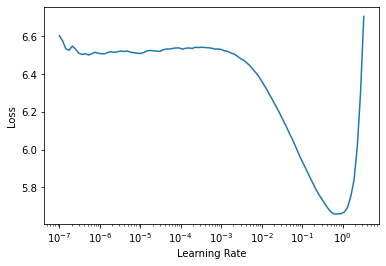

In [ ]:
learn_lm.lr_find(suggestions=True)

In [ ]:
doc(Learner.fine_tune)

In [ ]:
lr=1e-2

In [ ]:
learn_lm.fine_tune(epochs=3, base_lr=lr)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,5.276912,3.852003,0.315016,47.087299,00:14


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.046282,3.538154,0.352984,34.403339,00:15
1,3.818501,3.393587,0.369528,29.772551,00:15
2,3.671724,3.367341,0.373283,29.001310,00:15


In [ ]:
learn_lm.save_encoder(file='fine_tuned_enc')

## DataBlock for TextRegression

In [ ]:
doc(TextBlock.from_df)

In [ ]:
doc(SpacyTokenizer)

In [ ]:
txt_blk_reg = TextBlock.from_df(text_cols='safe_text', vocab=dls_lm.vocab, is_lm=False, tok_func=SpacyTokenizer)

In [ ]:
vaccinate_reg = DataBlock(blocks=(txt_blk_reg, RegressionBlock),
                          get_x=ColReader(cols='text'),
                          get_y=ColReader(cols='label'),
                          splitter=RandomSplitter(valid_pct=0.2, seed=42))

In [ ]:
vaccinate_reg.summary(source=train_df)

Setting-up type transforms pipelines
0      CL1KWCMY  ...  1.000000
1      E3303EME  ...  1.000000
2      M4IVFSMS  ...  1.000000
3      1DR6ROZ4  ...  1.000000
4      J77ENIIE  ...  1.000000
...         ...  ...       ...
9996   IU0TIJDI  ...  1.000000
9997   WKKPCJY6  ...  0.666667
9998   ST3A265H  ...  1.000000
9999   6Z27IJGD  ...  1.000000
10000  P6190L3Q  ...  0.666667

[9999 rows x 4 columns]
Found 9999 items
2 datasets of sizes 8000,1999
Setting up Pipeline: ColReader -> Tokenizer -> Numericalize


Setting up Pipeline: ColReader -> RegressionSetup

Building one sample
  Pipeline: ColReader -> Tokenizer -> Numericalize
    starting from
      tweet_id                                                                                                                                                                                                                    HF5RFML5
label                                                                                                                                                                                                                              0
agreement                                                                                                                                                                                                                   0.666667
text           [xxbos, i, find, it, hard, to, believe, that, no, one, saw, a, problem, with, ", diplomatic, immunity, ., ", xxmaj, it, 's, like, a, pass, to, go, on, a

Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: partial
Setting up after_batch: Pipeline: 

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (TensorText of size 40, tensor(0.))
    applying ToTensor gives
      (TensorText of size 40, tensor(0.))

Adding the next 3 samples

Applying before_batch to the list of samples
  Pipeline: partial
    starting from
      [(TensorText of size 40, tensor(0.)), (TensorText of size 28, tensor(0.)), (TensorText of size 27, tensor(1.)), (TensorText of size 33, tensor(1.))]
    applying partial gives
      [(TensorText of size 40, tensor(0.)), (TensorText of size 40, tensor(0.)), (TensorText of size 40, tensor(1.)), (TensorText of size 40, tensor(1.))]

Collating items in a batch

No batch_tfms to apply


In [ ]:
dls_reg = vaccinate_reg.dataloaders(source=train_df, verbose=True, bs=64, seq_len=72)

Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: partial
Setting up after_batch: Pipeline: 


In [ ]:
x, y = dls_reg.one_batch()

In [ ]:
x.shape, y.shape # One would expect seq_len as 72 but we get 53 Why???

(torch.Size([64, 53]), torch.Size([64]))

In [ ]:
dls_reg.show_batch()

,text,text_
0,"xxbos < user > xxmaj how xxmaj could xxmaj you xxmaj put xxmaj ur xxmaj child xxmaj in xxmaj so xxmaj much xxmaj danger ? xxmaj most xxmaj of xxmaj the xxmaj diseases xxmaj that xxmaj they xxmaj have xxmaj vaccines 4 , i xxmaj had xxmaj xxunk . xxmaj vaccinate . xxunk",1.0
1,"xxbos am - news : xxmaj week xxmaj ahead : xxup xxunk in the xxup er , xxup hiv xxmaj news , xxmaj docs on xxmaj measles xxmaj vaccine : xxmaj week xxmaj ahead : xxup xxunk in the xxup er , xxup hiv xxmaj news , xxmaj docs … < url >",0.0
2,xxbos xxup like xxup why xxup the xxup fuck xxup are xxup people xxup not xxup vaccinating xxup their xxup kids ? ! ? ! ? ! i xxup do nt xxup get xxup it & & xxup it xxup xxunk xxup me xxup off xxrep 3 !,1.0
3,xxbos i xxmaj know xxmaj i 'm xxmaj late xxup af xxmaj but xxmaj happy # xxunk xxmaj to xxmaj my xxmaj xxunk < user > xxmaj turn xxmaj up xxmaj lil xxmaj bro ! 💯 # xxup mmr @ xxup xxunk xxmaj south … < url >,0.0
4,"xxbos < user > < user > xxmaj ppl xxmaj need 2 xxmaj immunize xxmaj their xxmaj kids . xxmaj do xxmaj research . xxmaj most xxmaj diseases xxup worse xxup than xxup inoculation . xxup stop xxmaj this xxmaj misguided xxmaj insanity , xxmaj shots !",1.0
5,"xxbos xxmaj let 's get this straight , first it was xxup isis , then it was xxmaj ebola , then back to xxup isis , and now … xxmaj measles ? xxmaj fake xxup isis threats ? xxmaj yep . xxmaj fear . xxmaj fear .",0.0
6,"xxbos < user > < user > < user > xxup smdh # xxmaj flu # xxmaj vaccines , # xxmaj pharma # xxmaj fraud , # xxmaj quack # xxmaj science , the # xxup cdc & & # xxup who # health < url >",-1.0
7,"xxbos xxup not inspiring to hear xxmaj another xxmaj xxunk in the xxmaj xxunk this xxup am . xxmaj my gr 8 class voted to sing it at grad ( xxunk ) & & then i heard it on xxup mmr , not xxup xxunk .",0.0
8,"xxbos [ to roommate ] \n "" we should go get flu vaccines . "" \n xxmaj why ? \n "" well , the flu is n't a great a great disease . "" \n xxmaj the flu is fine . \n "" ok . """,0.0


## Regression Learner

In [ ]:
doc(text_classifier_learner)

In [ ]:
learn_reg = text_classifier_learner(dls=dls_reg, 
                                    arch=AWD_LSTM, 
                                    pretrained=True,
                                    loss_func=MSELossFlat(),
                                    metrics=[rmse],
                                    y_range=(-1.2, 1.2)
                                    ) # Loss func ?? Metrics ??? y_range??? encoder ???

In [ ]:
learn_reg.load_encoder('fine_tuned_enc')

In [ ]:
learn_reg.summary()

SequentialRNN (Input shape: ['64 x 53'])
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           64 x 53 x 400        0          False     
________________________________________________________________
RNNDropout           64 x 53 x 1152       0          False     
________________________________________________________________
RNNDropout           64 x 53 x 1152       0          False     
________________________________________________________________
BatchNorm1d          64 x 1200            2,400      True      
________________________________________________________________
Dropout              64 x 1200            0          False     
________________________________________________________________
Linear               64 x 50              60,000     True      
________________________________________________________________
ReLU                 64 x 50              0          False     
_________________________________________________________

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=9.12010818865383e-07)

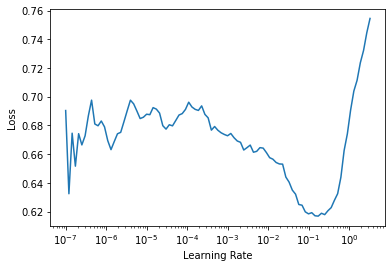

In [ ]:
learn_reg.lr_find()

In [ ]:
lr=1e-2

In [ ]:
learn_reg.fine_tune(epochs=3, base_lr=lr)

epoch,train_loss,valid_loss,_rmse,time
0,0.517643,0.393474,0.627276,00:11


epoch,train_loss,valid_loss,_rmse,time
0,0.407758,0.361201,0.601000,00:13
1,0.345667,0.342141,0.584928,00:13
2,0.292315,0.336554,0.580133,00:13


## Predictions

In [ ]:
test_df

,tweet_id,safe_text
0,00BHHHP1,"<user> <user> ... &amp; 4 a vaccine given 2 healthy peeps, FDA think just not worth the AE risk unfortunately."
1,00UNMD0E,Students starting school without whooping cough vaccinations <url> #scpick
2,01AXPTJF,"I'm kinda over every ep of <user> being ""ripped from the headlines."" Measles? Let's get back to crime. #SVU"
3,01HOEQJW,How many innocent children die for lack of vaccination each year? Around 1.5 million. Too bad all their parents couldn't be here. #SB277
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though risk is low: Federal officials said Wednesday they're taking steps… <url>"
...,...,...
5172,ZXVVNC5O,jenny mccarthy is on new years rockin eve. what has she done lately besides not vaccinate her kids and give us all goddamn polio??
5173,ZYIANVI8,Measles reported in Clark Co. for 1st time since 2011 <url>
5174,ZYITEHAH,"<user> issues alert regarding Measles in TX. Keep your DDx up to date, people! #Emergencymedicine"
5175,ZZ3BMBTG,I can't believe people don't vaccinate their kids! I've been vaccinated for everything and then some.


In [ ]:
doc(learn_reg.dls.test_dl)

In [ ]:
test_dl = learn_reg.dls.test_dl(test_items=test_df['safe_text'], verbose=True)

In [ ]:
doc(learn_reg.get_preds)

In [ ]:
learn_reg.get_preds(dl=test_dl, with_decoded=True)

(tensor([[-0.0063],
         [ 0.8084],
         [ 0.2124],
         ...,
         [ 0.2862],
         [ 0.8839],
         [ 0.4553]]), None, tensor([[-0.0063],
         [ 0.8084],
         [ 0.2124],
         ...,
         [ 0.2862],
         [ 0.8839],
         [ 0.4553]]))

In [ ]:
preds, _ , preds_raw = learn_reg.get_preds(dl=test_dl, with_decoded=True)

## Submissions

In [ ]:
vaccinate_tweets.ls()

(#4) [Path('SampleSubmission.csv'),Path('Train.csv'),Path('Test.csv'),Path('models')]

In [ ]:
submission = pd.read_csv(vaccinate_tweets/'SampleSubmission.csv')

In [ ]:
submission.head()

,tweet_id,label
0,00BHHHP1,0
1,00UNMD0E,0
2,01AXPTJF,0
3,01HOEQJW,0
4,01JUKMAO,0


In [ ]:
submission['label'] = preds.flatten()

In [ ]:
submission.head()

,tweet_id,label
0,00BHHHP1,-0.006287
1,00UNMD0E,0.808357
2,01AXPTJF,0.212385
3,01HOEQJW,0.994107
4,01JUKMAO,0.177752


Yaaaaaaaaaaaaaaaaaaayyyyyyy!!!!!

In [ ]:
submission.to_csv('first_baseline.csv', index=False)

## Future Ideas to try

- [Data] Preprocessing
   * SentencePiece (subword tokenization)
- [Data] Language Model
   * Incorporate additional data during language model (eg: test set, additional social media datasets)
- [Model] Ensembling using K fold cross validation [TODO : Link] : average of all predictions.
- [Model] Transformer variants, AWD_QRNN
- [Model] Blending : Models with higher predictions will get higher weights where as models with lower predictions will get lower weights [TODO: Link] 
- [Model] Mixed Precision Training
- [Model] Use fit_one_cycle and customize the learning rate. 
- [Optimizer] Currently we use ADAM, try with RADAM, Ranger optimizer variants
- [HyperParameter Tuning] Play with hyperparameters
- [Experiment Tracking] Integrating callbacks for Weights and Biases [TODO: Link]  


